<a href="https://colab.research.google.com/github/Hirakhan15/PCOs/blob/main/pcos1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf

# 1. Define where your data is (Paste your path here)
data_dir = '/content/drive/MyDrive/PCOS'

# 2. Load images and split them: 80% for learning, 20% for testing
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224), # Standard size for MobileNet
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

Found 11784 files belonging to 2 classes.
Using 9428 files for training.
Found 11784 files belonging to 2 classes.
Using 2356 files for validation.


In [3]:
import tensorflow as tf

# Define the MobileNetV3 base model (This needs to be done before it's used)
base_model = tf.keras.applications.MobileNetV3Small(input_shape=(224, 224, 3),
                                                  include_top=False,
                                                  weights='imagenet')
# Freeze the base model initially
base_model.trainable = False

# 1. Define the Augmentation (This makes the model study harder)
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.CenterCrop(180, 180), # NEW: Cuts out the machine text/borders
  tf.keras.layers.Resizing(224, 224),   # Resizes back for MobileNet
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
])

# 2. Re-build the model with the "Anti-Cheating" layers
model = tf.keras.Sequential([
    data_augmentation,           # NEW: Flips and rotates images randomly
    base_model,                  # Your MobileNetV3 brain
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5), # NEW: Randomly shuts off half the brain to prevent memorizing
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# 3. Re-compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# --- STEP 1: Calculate Weights ---
# This balances the 6,784 Infected vs 5,000 Healthy images
total_images = 6784 + 5000
weight_for_0 = (1 / 5000) * (total_images / 2.0)  # Weight for 'noninfected'
weight_for_1 = (1 / 6784) * (total_images / 2.0)  # Weight for 'infected'

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for Healthy (Class 0): {weight_for_0:.2f}")
print(f"Weight for PCOS (Class 1): {weight_for_1:.2f}")

Weight for Healthy (Class 0): 1.18
Weight for PCOS (Class 1): 0.87


In [5]:
# --- STEP 2: Enhanced Training ---

# 1. Define Callbacks to prevent overfitting
# EarlyStopping stops training if the model stops improving
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# ReduceLROnPlateau slows down the learning if it gets stuck
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

# 2. Run the Training
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,               # We use 15, but EarlyStopping might stop it at 10 or 12
    class_weight=class_weight, # This fixes the 6k vs 5k imbalance
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/15
295/295 ━━━━━━━━━━━━━━━━━━━━ 652s 2s/step - accuracy: 0.6959 - loss: 0.5834 - val_accuracy: 0.9287 - val_loss: 0.2167 - learning_rate: 0.0010
Epoch 2/15
295/295 ━━━━━━━━━━━━━━━━━━━━ 225s 762ms/step - accuracy: 0.9013 - loss: 0.2440 - val_accuracy: 0.9321 - val_loss: 0.1685 - learning_rate: 0.0010
Epoch 3/15
295/295 ━━━━━━━━━━━━━━━━━━━━ 228s 772ms/step - accuracy: 0.9216 - loss: 0.1995 - val_accuracy: 0.9452 - val_loss: 0.1490 - learning_rate: 0.0010
Epoch 4/15
295/295 ━━━━━━━━━━━━━━━━━━━━ 255s 748ms/step - accuracy: 0.9192 - loss: 0.1949 - val_accuracy: 0.9419 - val_loss: 0.1430 - learning_rate: 0.0010
Epoch 5/15
295/295 ━━━━━━━━━━━━━━━━━━━━ 220s 746ms/step - accuracy: 0.9255 - loss: 0.1796 - val_accuracy: 0.9402 - val_loss: 0.1375 - learning_rate: 0.0010
Epoch 6/15
295/295 ━━━━━━━━━━━━━━━━━━━━ 221s 747ms/step - accuracy: 0.9373 - loss: 0.1671 - val_accuracy: 0.9516 - val_loss: 0.1288 - learning_rate: 0.0010
Epoch 7/15
295/295 ━━━━━━━━━━━━━━━━━━━━ 216s 728ms/step - accuracy:

In [6]:
if 'train_ds' in globals() and 'val_ds' in globals():
    print("'train_ds' and 'val_ds' are defined.")
else:
    print("'train_ds' or 'val_ds' are not defined. Please ensure the data loading cell is executed.")

'train_ds' and 'val_ds' are defined.


In [7]:
# 1. Unfreeze the base model
base_model.trainable = True

# 2. Re-compile with a VERY SMALL learning rate
# We use 0.00001 so we don't "break" the pre-trained brain
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 3. Train for 5 more epochs
model.fit(train_ds, validation_data=val_ds, epochs=5, class_weight=class_weight)

Epoch 1/5
295/295 ━━━━━━━━━━━━━━━━━━━━ 572s 2s/step - accuracy: 0.7814 - loss: 0.5586 - val_accuracy: 0.9419 - val_loss: 0.1239
Epoch 2/5
295/295 ━━━━━━━━━━━━━━━━━━━━ 546s 2s/step - accuracy: 0.8637 - loss: 0.3380 - val_accuracy: 0.9435 - val_loss: 0.1221
Epoch 3/5
295/295 ━━━━━━━━━━━━━━━━━━━━ 541s 2s/step - accuracy: 0.9085 - loss: 0.2318 - val_accuracy: 0.9393 - val_loss: 0.1240
Epoch 4/5
295/295 ━━━━━━━━━━━━━━━━━━━━ 548s 2s/step - accuracy: 0.9238 - loss: 0.1916 - val_accuracy: 0.9393 - val_loss: 0.1246
Epoch 5/5
295/295 ━━━━━━━━━━━━━━━━━━━━ 554s 2s/step - accuracy: 0.9368 - loss: 0.1684 - val_accuracy: 0.9393 - val_loss: 0.1256


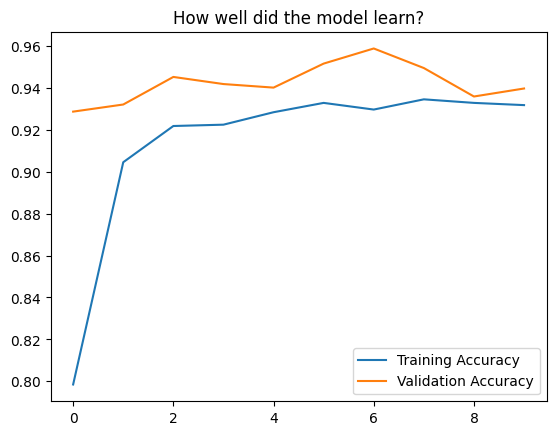

In [8]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('How well did the model learn?')
plt.legend()
plt.show()

In [9]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Get the actual labels (y_true) and the model's guesses (y_pred)
y_true = []
y_pred = []

# Loop through the validation dataset
for images, labels in val_ds:
    predictions = model.predict(images)

    # Since we used 'sigmoid' (binary), predictions are decimals like 0.8 or 0.2
    # We convert them to 1 (Infected) or 0 (Not Infected)
    y_pred.extend((predictions > 0.5).astype(int).flatten())
    y_true.extend(labels.numpy().astype(int).flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

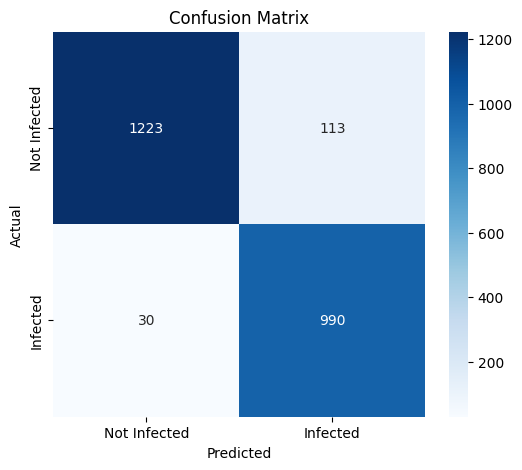

In [10]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Infected', 'Infected'],
            yticklabels=['Not Infected', 'Infected'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [11]:
print(classification_report(y_true, y_pred, target_names=['Not Infected', 'Infected']))

              precision    recall  f1-score   support

Not Infected       0.98      0.92      0.94      1336
    Infected       0.90      0.97      0.93      1020

    accuracy                           0.94      2356
   macro avg       0.94      0.94      0.94      2356
weighted avg       0.94      0.94      0.94      2356

